In [1]:
import h5py
import numpy as np
import glob2
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd


/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# All params
Q_list = [0.15]
W_list = [0.15]
D_list = [0.6]
T_list = [0.00001, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
decay_list = [18.0]

seed_list = list(np.arange(0, 25))

In [3]:
n_experiments = len(T_list)
n_timesteps = 8000
n_trials = 25

### Plot distance and number of scenters for optimal Ts of wb=0 and wb=5

In [4]:
def make_df(data, data_type, optimal_T, bias, stepsize=1, smoothing=True):
    
    distances = data[f'Q0.15_W0.15_D0.6_T{optimal_T:0.5f}_wb{bias:0.1f}_decay18.0']
    
    # Get the mean distances over 25 trials/seeds
    # distance_means = []
    # for trial_i, trial in enumerate(distances):
    #     distance_means.append(distances[trial])
    # distance_means_array = np.mean(np.array(distance_means), axis=0)
    all_distances = []
    for key, val in distances.items():
        all_distances.append(val)
        
    n_timesteps = len(val)
    all_distances_np = np.array(all_distances)
    
    # Smooth data 
    if smoothing:
        shape = all_distances_np.shape
        all_distances_np = np.reshape(all_distances_np, (shape[0], shape[1]//stepsize, stepsize))
        all_distances_np = all_distances_np.mean(axis=2)
    else:
        all_distances_np = all_distances_np[:,::stepsize]
    
    n_trials, n_timesteps = all_distances_np.shape
    
    all_distances = all_distances_np.flatten()
    
    # Make dataframes and concatenate 
    # Distances
    distance_df = pd.DataFrame(data=all_distances, columns=[data_type])

    # Time
    timesteps_np = np.tile(list(range(0, n_timesteps*stepsize, stepsize)), 1*n_trials)
    timesteps_df = pd.DataFrame(data=timesteps_np, columns=['Time'])

    # Optimal threshold
    T_params_list = np.array(optimal_T).repeat(n_timesteps*n_trials)
    T_params_df = pd.DataFrame(data=T_params_list, columns=['Threshold'])

    # Bias
    if bias:
        bias_on_np = np.ones(T_params_list.shape[0]) * 5
        bias_df = pd.DataFrame(data=bias_on_np, columns=['Bias'])
    else:
        bias_on_np = np.zeros(T_params_list.shape[0])
        bias_df = pd.DataFrame(data=bias_on_np, columns=['Bias'])

    # Total dataframe
    df = pd.concat((timesteps_df, distance_df, T_params_df, bias_df), axis=1)
    
    return df, n_timesteps 

In [5]:
def read_data(density):
    
    # Distance data 
    filename = f"distance_data/wb=0/distance_data_n={density}.json"
    filename2 = f"distance_data/wb=5/distance_data_n={density}.json"

    with open(filename) as f:
        distance_data_wb0 = json.load(f)

    with open(filename2) as f:
        distance_data_wb5 = json.load(f)

    # Scenter data
    s_filename = f"scenting_data/wb=0/state_data_{density}.json"
    s_filename2 = f"scenting_data/wb=5/state_data_{density}.json"

    with open(s_filename) as f:
        scenter_data_wb0 = json.load(f)

    with open(s_filename2) as f:
        scenter_data_wb5 = json.load(f)
        
    return distance_data_wb0, distance_data_wb5, scenter_data_wb0, scenter_data_wb5

In [6]:
def create_distance_scenter_dfs(distance_data_wb0, distance_data_wb5, 
                               scenter_data_wb0, scenter_data_wb5, 
                               wb0_optimalT, wb5_optimalT,
                               stepsize):
    
    df_wb0, n_timesteps = make_df(distance_data_wb0, 'Distance', wb0_optimalT, 0, stepsize)
    df_wb5, n_timesteps = make_df(distance_data_wb5, 'Distance', wb5_optimalT, 5, stepsize)
    df = pd.concat((df_wb0, df_wb5), axis=0)
    
    df_s_wb0, n_timesteps = make_df(scenter_data_wb0, 'NumScenters', wb0_optimalT, 0, stepsize)
    df_s_wb5, n_timesteps = make_df(scenter_data_wb5, 'NumScenters', wb5_optimalT, 5, stepsize)
    df_s = pd.concat((df_s_wb0, df_s_wb5), axis=0)
    
    return df, df_s

In [7]:
def plot(ax, df, df_s, wb0_optimalT, wb5_optimalT, density):
    
    sns.set(style="ticks", font_scale=1.15)
    
    palette = sns.color_palette("Set2", 2, 1)
    palette2 = sns.color_palette("Set2", 2, 1)

    # Distance curves
    sns.lineplot(x='Time', y='Distance', hue='Bias', data=df, markers='o',
                 estimator=np.mean, ci=None, palette=palette, ax=ax)
    
    for line in ax.lines:
        line.set_linestyle("--")

    ax.set(xlabel='Time', ylabel='Distance to queen', ylim=(0, 2))

    # Distance legend
    handles, labels = ax.get_legend_handles_labels()
    labels = [f"wb=0, T={wb0_optimalT:0.3f}, Distance to queen", f"wb=5, T={wb5_optimalT:0.3f}, Distance to queen"]
    leg = ax.legend(handles=handles[1:], labels=labels[0:], 
               title="Bias (wb), Optimal Threshold (T)", loc=(1.15, 0.45), frameon=False)
    leg_lines = leg.get_lines()
    
    for line in leg_lines:
        line.set_linestyle("--")

    # NumScenters curves
    ax2 = ax.twinx()
    sns.lineplot(x='Time', y='NumScenters', hue='Bias', data=df_s, 
                 estimator=np.mean, ci=None, palette=palette2, ax=ax2)

    ax2.set(ylabel='Number of scenters', ylim=(0, int(density)))

    # Scenters legend
    handles2, labels2 = ax2.get_legend_handles_labels()
    labels = [f"wb=0, T={wb0_optimalT:0.3f}, Number of scenters", f"wb=5, T={wb5_optimalT:0.3f}, Number of scenters"]
    leg2 = ax2.legend(handles=handles[1:], labels=labels[0:], loc=(1.15, 0.175), frameon=False)
    leg_lines_2 = leg2.get_lines()
    
    for line in leg_lines_2:
        line.set_linestyle("-")
    
    # Fig setting
    ax.set_title(f"Worker density = {density}")
    ax.set_xlim(-150, 8000)
    sns.despine(right=False)

In [8]:
density_dict = {"35": [0.001, 0.01],  # Optimal T for wb=0 and wb=5
                "70": [0.001, 0.025],
                "140": [0.025, 0.1]
               }

Text(0.5,0.94,'Optimal thresholds')

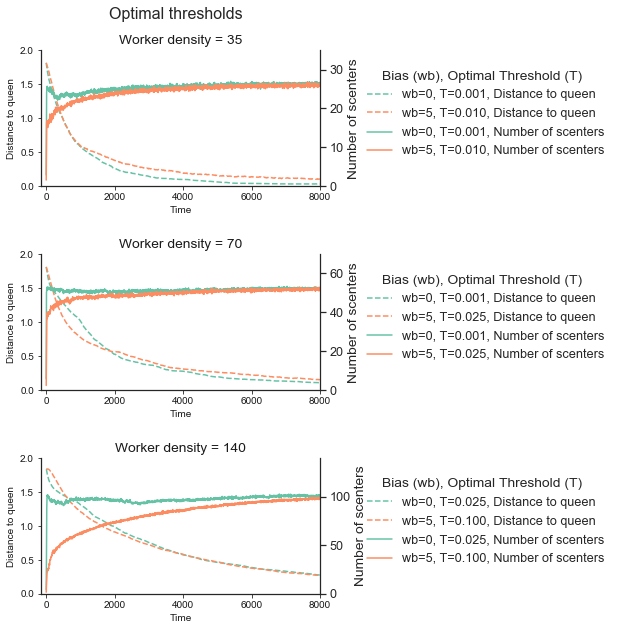

In [9]:
STEPSIZE = 4

fig, axs = plt.subplots(3, 1, figsize=(5, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for ax, density in zip(axs, density_dict):    
    wb0_optimalT = density_dict[density][0]
    wb5_optimalT = density_dict[density][1]

    distance_data_wb0, distance_data_wb5, scenter_data_wb0, scenter_data_wb5 = read_data(density)
    df, df_s = create_distance_scenter_dfs(distance_data_wb0, distance_data_wb5, 
                          3                 scenter_data_wb0, scenter_data_wb5, 
                                           wb0_optimalT, wb5_optimalT,
                                           STEPSIZE)
    plot(ax, df, df_s, wb0_optimalT, wb5_optimalT, density)
    
plt.suptitle('Optimal thresholds', size=16, x=0.5, y=0.94)
